Código "vetorizado" referente a solução aproximada via Galerkin do problema elíptico 1D transiente

Exemplo 1). $\alpha=\beta=1$

$u_0(x,0) = \frac{sen(π*x)}{π²}  $

$f(x,t) = sen(π*x)*e^{-t}$,

$u(x,t) = \frac{sen(π*x)*e^{-t}}{π²} $


In [9]:
import time
import numpy as np
from numpy import array
from scipy.special import roots_legendre
from scipy import sparse
import matplotlib.pyplot as plt

In [10]:
# Dados de entrada do exemplo 1
def dados_de_entrada(exemplo):
  if exemplo == 1:

    alpha = 1; beta  = 1

    def f(x,t):
      return np.sin(np.pi*x)*np.exp(-t)

    def u_0(x):
      return (1/(np.pi)**2)*np.sin(np.pi*x)

    def u(x,t):
      return (1/(np.pi)**2)*np.sin(np.pi*x)*np.exp(-t)

  return alpha, beta, f, u, u_0

Definiremos as matrizes/vetores que serão usadas

P: vetor 1 x npg contendo os pontos da QG

W: vetor 1 x npg contendo os pesos da QG

phiP: matriz 2 x npg contendo as funçoes phi_0 e phi_1 nos pontos de gauss

dphiP: matriz 2 x npg contendo as funçoes dphi_0 e dphi_1 nos pontos de gauss

xPTne: matriz npg x ne onde em cada coluna terá o ponto de gauss aplicado na
x apos a mudança de variável

LG: matriz 2 x ne que estabelece a relação localXglobal

EQ: vetor 1 x (ne+1) contendo uma nova numeração para as funçoes base globais

EQoLG: matriz 2 x ne contendo a corespondencia localXglobal apos o processo de reenumeração


In [11]:
# Definir as funçoes para montar as estruturas acima

# Função phi(P): Calcula as funções phi_0(P) e phi_1(P)
def phi(P):
  return array([(1 - P) / 2, (1 + P) / 2 ])
                # phi_0(P)    # phi_1(P)

# Função dphi(P): Calcula as derivadas das funções phi_0(P) e phi_1(P)
def dphi(P):
  return array([-1/2*P**0,  1/2*P**0 ])

# Função monta_LG: Retorna a relação entre a numeração local e global das funções phi
def monta_LG(ne):
  return array([np.arange(0,ne),np.arange(1,ne+1)])

# Função monta_EQ: Retorna um vetor com a nova numeração das funções globais phi
def monta_EQ(ne):
  m = ne-1
  EQ = array([m, *np.arange(0,m), m])
  return EQ, m

# Função monta_EQoLG
def monta_EQoLG(ne):
  LG = monta_LG(ne)
  EQ, m = monta_EQ(ne)
  EQoLG = EQ[LG]
  return EQoLG, m

# Função monta_xPTne: Retorna um array 2D (npg,ne) com as coordenadas globais dos pontos de Gauss em todos os elementos
def monta_xPTne(h,P):
  return (h/2)*(P+1)[:,np.newaxis] + np.arange(0, 1, h)

In [12]:
# Montar as matrizes K e M

def monta_K_M(alpha,beta,EQoLG,m):
  ne = EQoLG.shape[1]; h = 1/ne

  npg = 2; P, W = roots_legendre(npg)

  phiP = phi(P); dphiP = dphi(P)
  Ke = (2*alpha/h)*(W*dphiP)@dphiP.T + (beta*h/2)*(W*phiP)@phiP.T # @ produto matricial
  Me = (h/2)*(W*phiP)@phiP.T


  S1 = Ke.reshape(-1).repeat(ne)
  S2 = Me.reshape(-1).repeat(ne)
  I = EQoLG[[0,1,0,1],:].reshape(-1)
  J = EQoLG[[0,0,1,1],:].reshape(-1)

  K = sparse.coo_matrix((S1,(I,J)),shape=(m+1,m+1)).tocsr()[:-1, :-1] #acumula as locais
  M = sparse.coo_matrix((S2,(I,J)),shape=(m+1,m+1)).tocsr()[:-1, :-1]
  return K, M

In [13]:
def monta_F(f,EQoLG,m,t):
  ne = EQoLG.shape[1]; h = 1/ne

  npg = 5; P, W = roots_legendre(npg)

  xPTne  = monta_xPTne(h,P)
  fxPTne = f(xPTne,t)
  locais = ((h/2)*W*phi(P))@fxPTne

  return np.bincount(EQoLG.reshape(-1), weights=locais.reshape(-1), minlength=m+1)[:-1]

In [14]:
def erro_L2(u,c,EQoLG,t):
  ne = EQoLG.shape[1]; h = 1/ne

  npg = 5; P, W = roots_legendre(npg)

  phiPT = phi(P).T

  xPTne  = monta_xPTne(h,P)
  uxPTne = u(xPTne,t)

  d = array([*c,0])
  dEQoLG = d[EQoLG]

  return np.sqrt( (h/2)*np.sum( W @ (uxPTne - phiPT@dEQoLG)**2 ) )

In [15]:
def Calor_1D(ne,tau,exemplo):
  alpha, beta, f, u, u_0 = dados_de_entrada(exemplo)
  h = 1/ne
  t = np.arange(0,1+tau,tau)
  N = t.shape[0]-1
  erroL2 = np.zeros(N+1)

  print("N",N)
  # Monta K e M
  EQoLG,m = monta_EQoLG(ne)
  K, M = monta_K_M(alpha,beta,EQoLG,m)

  # Inicializar C
  C = np.zeros((m,N+1))

  # Definir solucao no t inicial C(0)
  C[:,0] = u_0(np.arange(h,1,h))
  erroL2[0] = erro_L2(u,C[:,0],EQoLG,t[0])

  # Resolva o sistema linear Kc=F
  for n in range(0,N):
    F = monta_F(f,EQoLG,m,(t[n]+t[n+1])/2)
    C[:,n+1] = sparse.linalg.spsolve(M +(tau/2)*K,(M -(tau/2)*K)@C[:,n] + tau*F)

    # Calcula o erro entre a solução aproximada e exata
    erroL2[n+1] = erro_L2(u,C[:,n+1],EQoLG,t[n+1])
  LooL2 = np.max(erroL2)

  return C, LooL2

Vamos obter a soluçao aproximada e fazer oestudo da convergencia
do erro para o exemplo 1

In [18]:
exemplo = 1
ne = 4
h = 1/ne
tau = h
C, LooL2 = Calor_1D(ne,tau,exemplo)

print(LooL2)
print("C",C)

N 4
0.003980336614548415
C [[0.0716449  0.0552331  0.04311411 0.03356009 0.02613963]
 [0.10132118 0.0781114  0.06097255 0.04746113 0.03696702]
 [0.0716449  0.0552331  0.04311411 0.03356009 0.02613963]]


N 4
N 8
N 16
N 32
N 64
N 128
N 256
N 512


'elapsed time'

1.5850551128387451

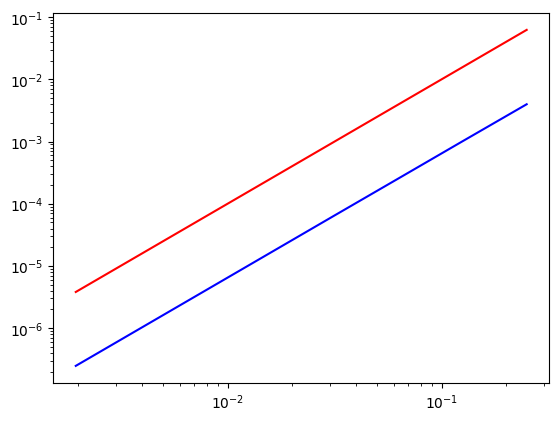

In [20]:
vec_ne = 2**np.arange(2,10)

# Inicialize os vetores para armazenar os valores de h e os erros
vec_h  = 1/vec_ne
vec_tau = vec_h
vec_erro = np.zeros(len(vec_h))

# Itere através de vec_ne
t = time.time()
for i in range(len(vec_ne)):
  ne = vec_ne[i]
  tau = vec_tau[i]
  C, vec_erro[i] = Calor_1D(ne,tau,exemplo) # Resolva o sistema linear Kc=F

elapsed = time.time() - t
display("elapsed time",elapsed)

# Exiba o gráfico do em erro em escala log
plt.loglog(vec_h,vec_erro,'b')
plt.loglog(vec_h,vec_h**2,'r')